## Example 1: Maximizing the Bulk Modulus of M<sub>2</sub>AX

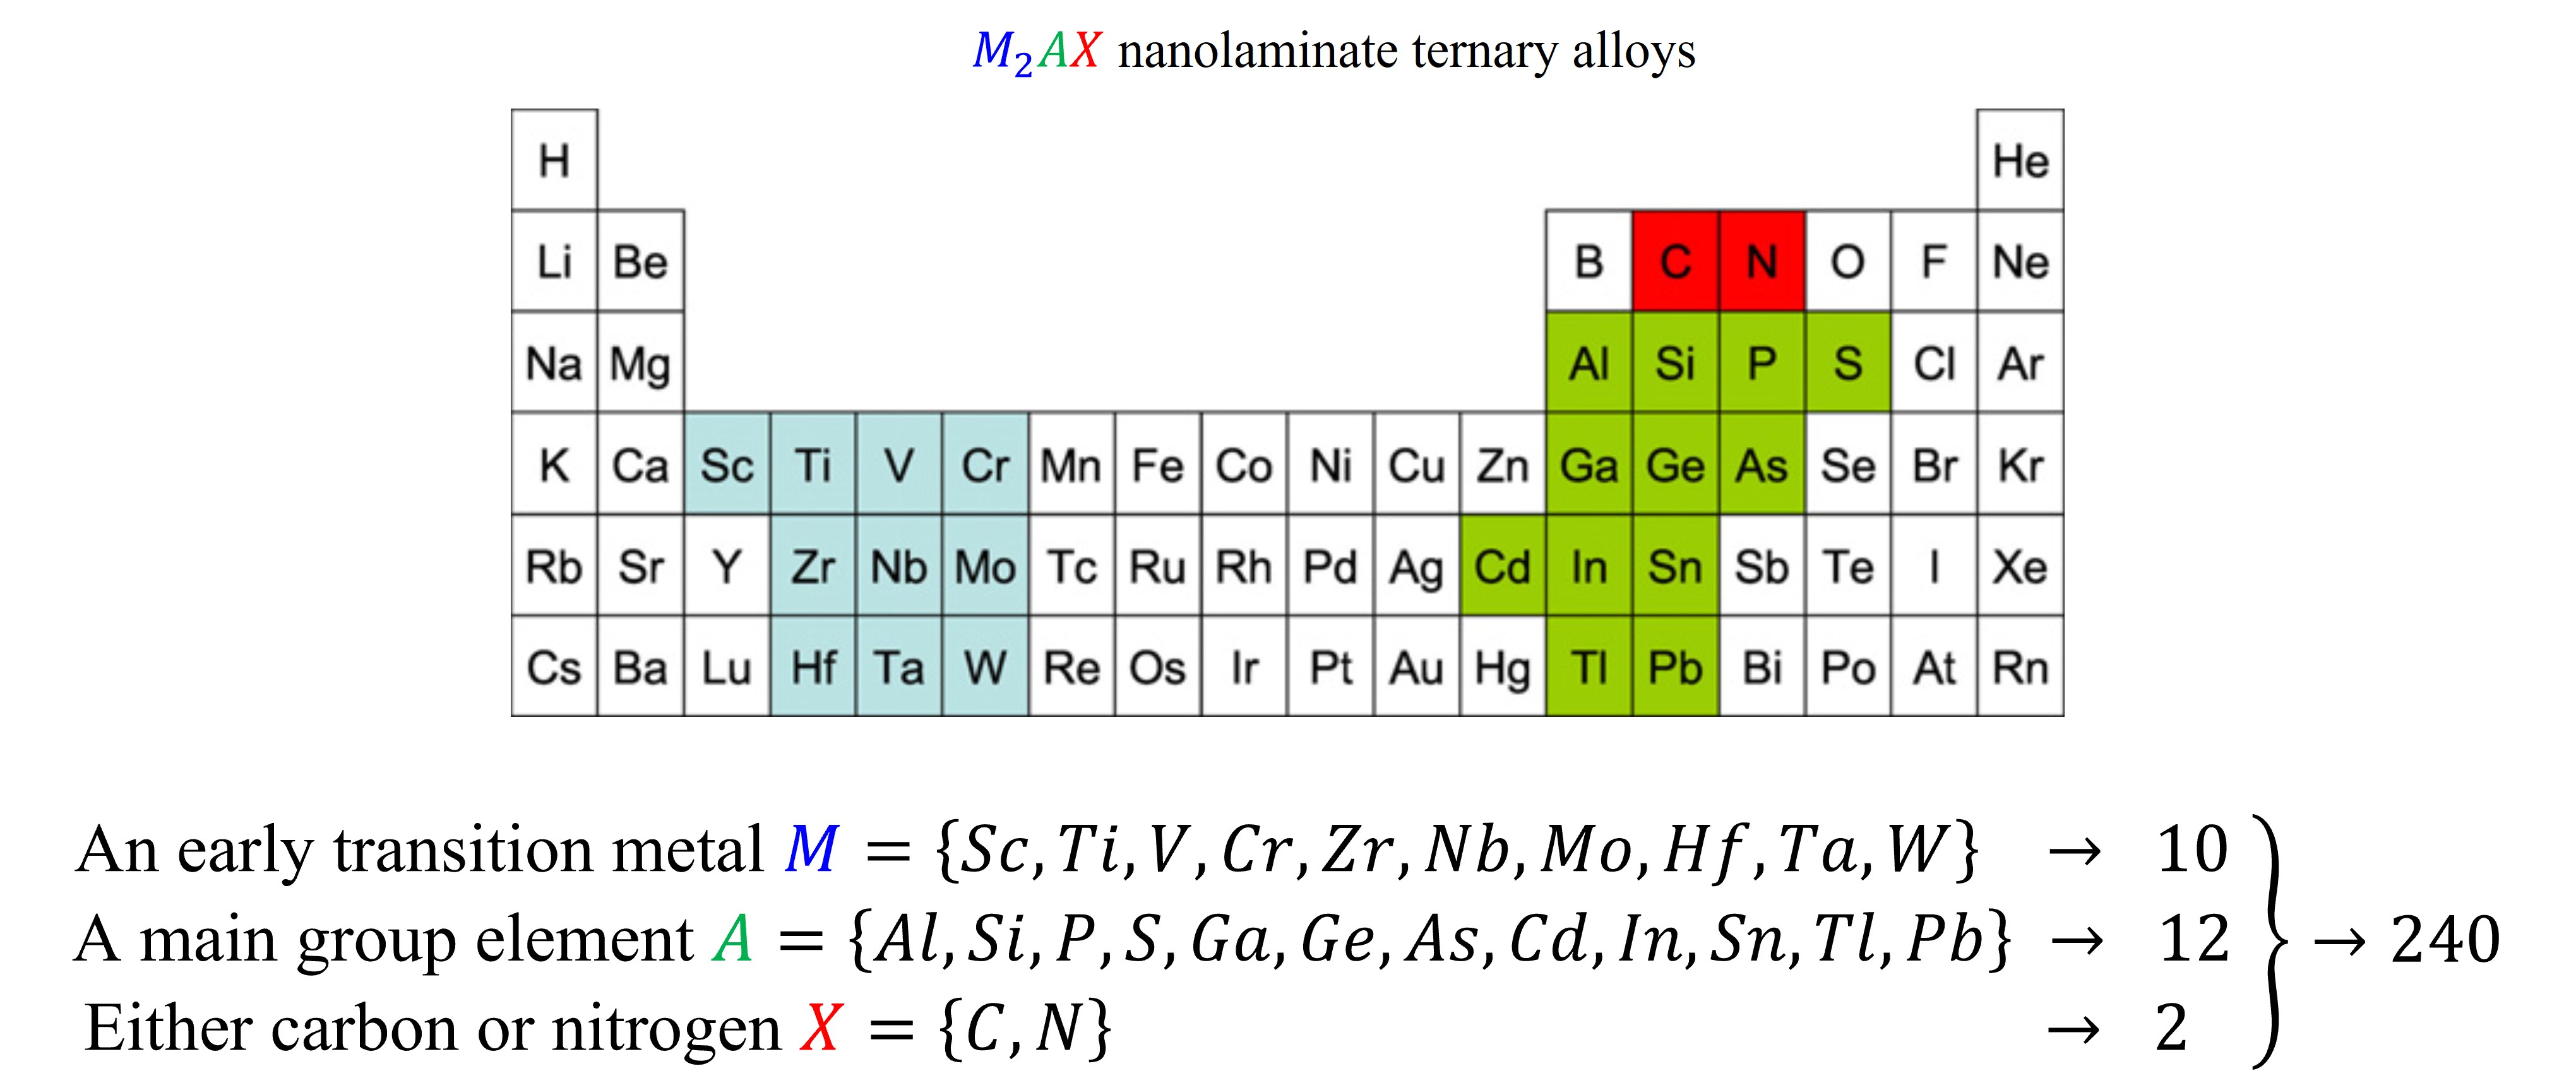

In [41]:
from IPython import display
display.Image("M2AX.jpg")

### 1. Import Libraries

In [38]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Plotly libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default = "notebook"

In [39]:
# sklearn library 
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import mean_squared_error as MSError

In [8]:
# scipy normal probability distribution for acquisition functions
from scipy.stats import norm
import warnings
# lolopy for Randomforest regression with uncertainity 
from lolopy.learners import RandomForestRegressor

### 2. Read data featurized from Matminer

In [9]:
data = pd.read_csv('./data_Matminer.csv')
data.head()

Unnamed: 0    6     7     8      9      10    11    12    13    14  ...  \
0           0  6.0  48.0  42.0  24.00  12.000  21.0  11.0  77.0  66.0  ...   
1           1  6.0  81.0  75.0  32.25  24.375  21.0  11.0  77.0  66.0  ...   
2           2  6.0  49.0  43.0  24.25  12.375  21.0  11.0  77.0  66.0  ...   
3           3  6.0  82.0  76.0  32.50  24.750  21.0  11.0  81.0  70.0  ...   
4           4  6.0  21.0  15.0  15.25   5.750  21.0  11.0  77.0  66.0  ...   

   141    142       143       144  Msiteelement  Asiteelement  Xsiteelement  \
0  0.0  False  0.298143  0.051176            Sc            Cd             C   
1  3.5  False  0.298143  0.051515            Sc            Tl             C   
2  0.0  False  0.298143  0.051271            Sc            In             C   
3  3.5  False  0.298143  0.064220            Sc            Pb             C   
4  0.0  False  0.298143  0.051593            Sc            Al             C   

   BBulkmodulus  GShearmodulus  EYoungsmodulus  
0            73             36              92  
1            84             55             135  
2            86             54             135  
3            87             58             142  
4            88             57             140  

[5 rows x 127 columns]

### 3. Split Train Test data

In [12]:
random_seed = 22

X = data.iloc[:,1:-6].to_numpy()
y = data.iloc[:,-3].to_numpy().astype(np.float64).reshape(-1,) 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True)
scaleX = StandardScaler()
scaley = StandardScaler()
Xtrain = scaleX.fit_transform(Xtrain)
Xtest = scaleX.transform(Xtest)

ytrain_n = scaley.fit_transform(ytrain.reshape(-1,1))
ytest_n = scaley.transform(ytest.reshape(-1,1))

print(f'The shape of train and test Xs are {Xtrain.shape}, {Xtest.shape}')

The shape of train and test Xs are (178, 120), (45, 120)


### 4. Fit Regression model

In [40]:
gp = GaussianProcessRegressor( kernel=Matern(nu=2.5, length_scale=np.ones((Xtrain.shape[-1]),)),  
            alpha=1e-6,
            normalize_y=True,
            n_restarts_optimizer=16,
            random_state= random_seed,
        )

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gp.fit(Xtrain, ytrain_n)
ypred_n, ystd_n = gp.predict(Xtest, return_std= True)
print(f'The score is {gp.score(Xtest, ytest_n)}')

The score is 0.9516337828043245


### 4. Plot  prediction Vs Actual for train and test

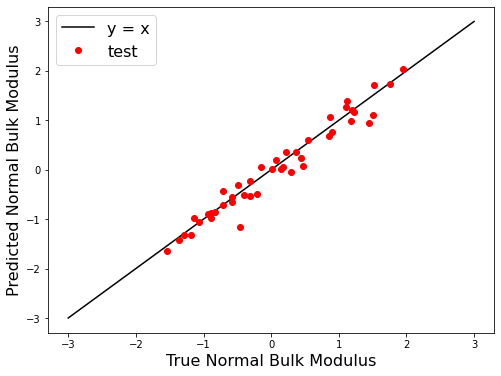

In [42]:
#ypred = scaley.inverse_transform(ypred_n).reshape(-1,)
plt.figure(figsize = (8,6))
plt.plot([round(np.min(ytest_n))-1, round(np.max(ytest_n))+1], 
    [round(np.min(ytest_n))-1, round(np.max(ytest_n))+1], color = 'black', label = 'y = x')
plt.plot(ytest_n, ypred_n, 'ro', label = 'test')
#plt.errorbar(ytest_n.reshape(-1,), ypred_n.reshape(-1,), yerr = ystd_n)
plt.legend(prop = {'size':16 })
plt.xlabel('True Normal Bulk Modulus', fontsize = 16)
plt.ylabel('Predicted Normal Bulk Modulus', fontsize = 16)
plt.show()


>-
### 5. Bayesian Optimization
>-

In [44]:
# Number of iteration for Bayesian Optimization to find the optimum
n_iteration = 50
# Initial number of data to start Bayesian Optimization
initial_numbers = 10
# Repetition of bayesian optimization for creating statistics
num_bayesian_random = 30

#### 5.1. Acquision Functions to test
>- Three acquision functions are tested here and compared agaisnt Random selection:
>- Probability of the improvement (PI)
>- Expected Improvement (EI)
>- Upper confidence bound
>- MEI maximum expected improvement (Citrine paper)
>- MU maximum Uncertainity (citrine paper)
>- MLI maximum likelihood of imporvement (MLI)

$$
P I(x)=\psi\left(\frac{\mu(x)-f\left(x^{+}\right)-\xi}{\sigma(x)}\right)
$$


$$
\begin{aligned}
E I(x)=&\left(\mu(x)-f\left(x^{+}\right)-\xi\right) \psi\left(\frac{\mu(x)-f\left(x^{+}\right)-\xi}{\sigma(x)}\right) +\sigma(x) \phi\left(\frac{\mu(x)-f\left(x^{+}\right)-\xi}{\sigma(x)}\right)
\end{aligned}
$$

$$
U C B(x)=\mu(x)+\beta \sigma(x)
$$


$$
MEI(x)={\mu(x)}
$$


$$
MU(x)={\sigma(x)}
$$


$$
MLI(x)=\left(\frac{\mu(x)-f\left(x^{+}\right)}{\sigma(x)}\right)
$$




In [45]:
####### probability of improvement ########
def PI(mean, std, bestf, si = 0):
    z = ((mean - bestf - si)/std)
    return norm.cdf(z)

####### Expected Improvment #########
def EI(mean, std, bestf, si = 0):
    z1 = (mean - bestf - si)
    z2 = z1/std
    return z1 * norm.cdf(z2) + std * norm.pdf(z2)

# Upper confidence Bound
def UCB(mean, std, bestf, beta = 1.0):
    return mean + beta * std

####### Maximum Expected Improvement #########
# maximum expected improvement #
def MEI(mean, std, bestf):
    return mean

####### Maximum Uncertainity #########
# maximum standard deviation
def MU(mean, std, bestf):
    return np.abs(std)

####### Maximum Likelihood Improvement #########
def MLI(mean, std, bestf):
    return (mean - bestf)/std

# random selection
def Random(y, seed):
    np.random.seed(seed)
    all_index = set(range(len(y)))
    chosen = set()
    bestf = []
    for i in range(len(y)):
        ind = np.random.choice(list(all_index), 1, replace=False)
        bestf.append(y[ind])
        all_index = all_index.difference(ind)
        if bestf[-1] == np.max(y):
            #print(f'Found the maximum at {len(bestf)-1}')
            break
    
    return bestf

#### 5.2. Define a Bayesian Optimization loop with the option of 
>- Different Acquisition functions
>- Gaussian process (GP)
>- RandomForestRegression (RF)
>- Seed number for generating statistics

In [46]:
def Bayesian_Optimization(X, y, acquisition_fun, model_type = 'GP', random_seed = 123):

    if model_type == 'RF':
        model = RandomForestRegressor()
    else:
        model = GaussianProcessRegressor( kernel=Matern(nu=2.5),
            alpha=1e-6,
            normalize_y=True,
            n_restarts_optimizer=16,
            random_state= random_seed,
        )

    np.random.seed(random_seed)
    chosen = np.random.choice(len(y)-1, initial_numbers, replace=False)
    bestf = []
    all_index = set(range(len(y)))
    chosen = set(chosen)
    for i in range(n_iteration):

        Xtrain = X[list(chosen),...]
        ytrain = y[list(chosen)]
        scale = StandardScaler()
        Xtrain = scale.fit_transform(Xtrain)
        remaining = all_index.difference(chosen)
        Xtest = scale.transform(X[list(remaining)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X = Xtrain, y = ytrain)
        yp, ystd = model.predict(Xtest, return_std = True)
        bestf.append(np.max(ytrain))
        acq_value = acquisition_fun(yp, ystd,  bestf = bestf[-1])
        next_point_index = list(remaining)[np.argmax(acq_value)]
        if next_point_index in chosen:
           print('ERR: Repetetive next point')
           return []
        chosen = set(np.append(list(chosen), next_point_index))

        if y[next_point_index] == np.max(y):
            bestf.append(np.max(y))
            #print(f'Found the maximum in {len(bestf)-1} steps')
            break

    return bestf


#### 5.3. Generating statistics for different Acquition functions 

In [47]:
#### Expected improvement 
bestf_history_EI = []
for j in range(num_bayesian_random):
    bestf_history_EI.append(Bayesian_Optimization(X, y, acquisition_fun=EI, model_type = 'GP', random_seed=j * 10))

num_steps_EI = [len(b) for b in bestf_history_EI]

In [48]:
#### Probability of Improvement
bestf_history_PI = []
for j in range(num_bayesian_random):
    bestf_history_PI.append(Bayesian_Optimization(X, y, acquisition_fun=PI, model_type = 'GP', random_seed=j * 10))

num_steps_PI = [len(b) for b in bestf_history_PI]

In [49]:
#### Upper confidence Bound
bestf_history_UCB = []
for j in range(num_bayesian_random):
    bestf_history_UCB.append(Bayesian_Optimization(X, y,acquisition_fun=UCB, model_type = 'GP', random_seed=j * 10))

num_steps_UCB = [len(b) for b in bestf_history_UCB]

In [50]:
#### Maximum Expected Improvement (MEI) 
bestf_history_MEI = []
for j in range(num_bayesian_random):
    bestf_history_MEI.append(Bayesian_Optimization(X, y,acquisition_fun=MEI, model_type = 'GP', random_seed=j * 10))

num_steps_MEI = [len(b) for b in bestf_history_MEI]

In [51]:
#### Maximum Uncertainity (MU) 
bestf_history_MU = []
for j in range(num_bayesian_random):
    bestf_history_MU.append(Bayesian_Optimization(X, y, acquisition_fun=MU, model_type = 'GP', random_seed=j * 10))

num_steps_MU = [len(b) for b in bestf_history_MU]

In [52]:
#### Maximum Likelihood of Improvement(MLI) 
bestf_history_MLI = []
for j in range(num_bayesian_random):
    bestf_history_MLI.append(Bayesian_Optimization(X, y, acquisition_fun=MLI, model_type = 'GP', random_seed=j * 10))

num_steps_MLI = [len(b) for b in bestf_history_MLI]

In [53]:
#### Random selection
bestf = []
for i in range(num_bayesian_random):
    bestf.append(Random(y, random_seed*i))

num_steps_random = [len(b) for b in bestf]

#### 5.4. Plotting statistics for EI and Random

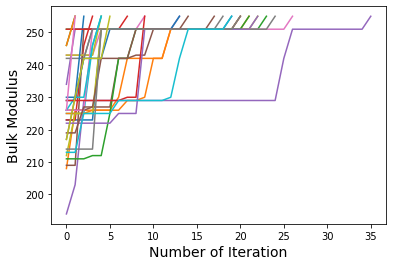

In [54]:
#### Plotting The 30 curves for EI as an example
for i in range(len(bestf_history_EI)):
    plt.plot(range(len(bestf_history_EI[i])), bestf_history_EI[i])

_ = plt.xlabel('Number of Iteration', fontsize = 14)
_ = plt.ylabel('Bulk Modulus', fontsize = 14)

##### 5.5. Plotting statistics for EI and Random

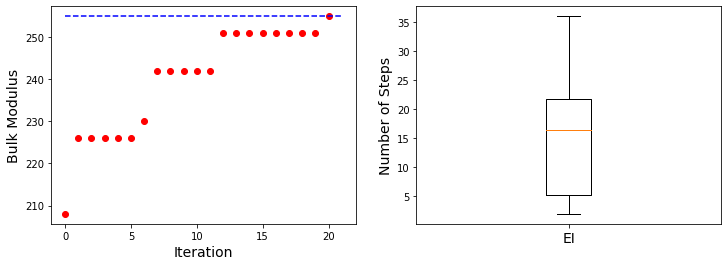

In [55]:
#### Plotting The curve for one example of EI and the boxplot of Number of stops to find the maximum for EI
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
_ = ax[0].plot(range(len(bestf_history_EI[1])), bestf_history_EI[1], 'ro')
ax[0].set_xlabel('Iteration', fontsize = 14)
ax[0].set_ylabel('Best Bulk Modulus', fontsize = 14)
ax[0].plot([0.0, len(bestf_history_EI[1])], [np.max(y), np.max(y)], 'b--')
_ = ax[1].boxplot(num_steps_EI)
plt.xticks([1], ['EI'], fontsize = 14)
_ = ax[1].set_ylabel('Number of Steps', fontsize = 14)

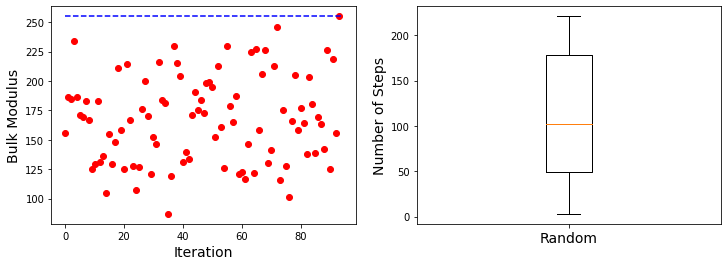

In [56]:
#### Plotting The curve for one example of Random and the boxplot of Number of steps to find the maximum for Random
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
_ = ax[0].plot(range(len(bestf[0])), bestf[0], 'ro')
_ = ax[0].set_xlabel('Iteration', fontsize = 14)
_ = ax[0].set_ylabel('Bulk Modulus', fontsize = 14)
_ = ax[0].plot([0.0, len(bestf[0])], [np.max(y), np.max(y)], 'b--')
_ = ax[1].boxplot(num_steps_random)
_ = plt.xticks([1], ['Random'], fontsize = 14)
_ = ax[1].set_ylabel('Number of Steps', fontsize = 14)

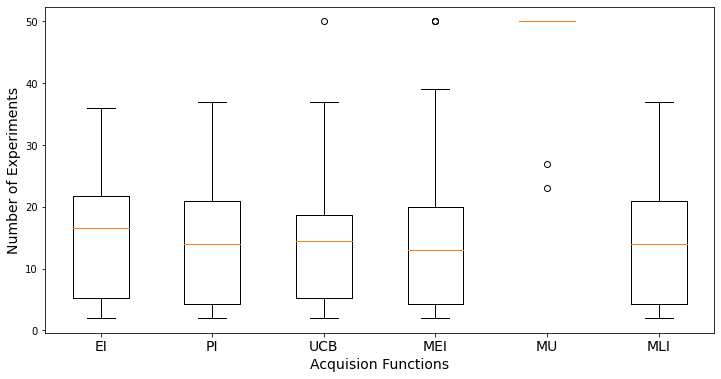

In [67]:
# Comparing different Acquisition functions
plt.figure(figsize=(12, 6))
_ = plt.boxplot([num_steps_EI, num_steps_PI, num_steps_UCB, num_steps_MEI, num_steps_MU, num_steps_MLI])
_ = plt.xticks([1, 2, 3, 4, 5, 6], ['EI', 'PI', 'UCB', 'MEI', 'MU', 'MLI'], fontsize = 14)
_ = plt.xlabel('Acquisition Functions', fontsize = 14)
_ = plt.ylabel('Number of Experiments', fontsize = 14)

### Conclusion
>- It takes on average 100 iterations for Random choice to find the maximum while with BO and good acquision function, e.g. EI, it takes about 12-15 steps.
>- Maximum Uncertainity acquisition function could not find the maximum in 30 iterations
>- The perfomance of other acquision functions are very similar and on average it takes 15 additional steps (after 10 initial) to find the maximum

>-
## Random Forest Regression
>-

### 1. Random Forest Regression model

In [59]:
#### Creating Xtrain, Xtest, ytrain and ytest again
X = data.iloc[:,1:-6].to_numpy()
y = data.iloc[:,-3].to_numpy().astype(np.float64).reshape(-1,) 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True)
scaleX = StandardScaler()
scaley = StandardScaler()
Xtrain = scaleX.fit_transform(Xtrain)
Xtest = scaleX.transform(Xtest)

ytrain_n = scaley.fit_transform(ytrain.reshape(-1,1))
ytest_n = scaley.transform(ytest.reshape(-1,1))

print(f'The shape of train and test Xs are {Xtrain.shape}, {Xtest.shape}')

The shape of train and test Xs are (178, 120), (45, 120)


In [60]:
# RandomForest Regression model from lolopy
RF =  RandomForestRegressor(num_trees=500)
RF.fit(Xtrain, ytrain_n)
ypred_n, ystd_n = RF.predict(Xtest, return_std= True)
print(f'The score is {RF.score(Xtest, ytest_n)}')

The score is 0.9059794688508787


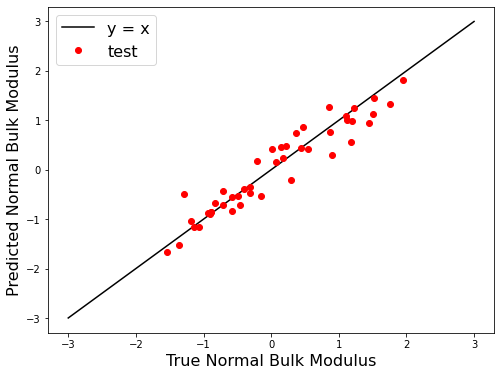

In [61]:
#### Plotting RandomForest Regression
plt.figure(figsize = (8,6))
plt.plot([round(np.min(ytest_n))-1, round(np.max(ytest_n))+1], 
    [round(np.min(ytest_n))-1, round(np.max(ytest_n))+1], color = 'black', label = 'y = x')
plt.plot(ytest_n, ypred_n, 'ro', label = 'test')
#plt.errorbar(ytest_n.reshape(-1,), ypred_n.reshape(-1,), yerr = ystd_n)
plt.legend(prop = {'size':16 })
plt.xlabel('True Normal Bulk Modulus', fontsize = 16)
plt.ylabel('Predicted Normal Bulk Modulus', fontsize = 16)
plt.show()

#### 2. Bayesian Optimization Random Forest Regression

In [68]:
#### Maximum Expected Improvement (MEI) 
bestf_history_MEI_RF = []
for j in range(num_bayesian_random):
    bestf_history_MEI_RF.append(Bayesian_Optimization(X, y, acquisition_fun=MEI, model_type='RF',random_seed=j * 10))

num_steps_MEI_RF = [len(b) for b in bestf_history_MEI_RF]

In [69]:
#### Maximum Uncertainity (MU) 
bestf_history_MU_RF = []
for j in range(num_bayesian_random):
    bestf_history_MU_RF.append(Bayesian_Optimization(X,y, acquisition_fun=MU, model_type='RF', random_seed=j * 10))

num_steps_MU_RF = [len(b) for b in bestf_history_MU_RF]

In [70]:
#### Maximum Likelihood of Improvement(MLI) 
bestf_history_MLI_RF = []
for j in range(num_bayesian_random):
    bestf_history_MLI_RF.append(Bayesian_Optimization(X,y, acquisition_fun=MLI, model_type='RF', random_seed=j * 10))

num_steps_MLI_RF = [len(b) for b in bestf_history_MLI_RF]

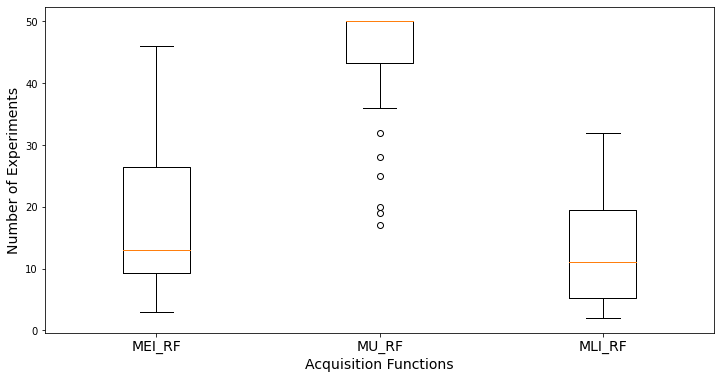

In [71]:
#### Boxplot for different Acquisition Functions
plt.figure(figsize=(12, 6))
_ = plt.boxplot([num_steps_MEI_RF, num_steps_MU_RF, num_steps_MLI_RF])
_ = plt.xticks([1, 2, 3], ['MEI_RF', 'MU_RF', 'MLI_RF'], fontsize = 14)
_ = plt.xlabel('Acquisition Functions', fontsize = 14)
_ = plt.ylabel('Number of Experiments', fontsize = 14)

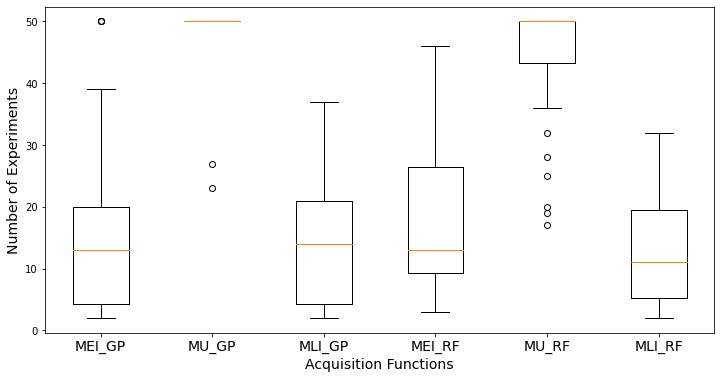

In [72]:
plt.figure(figsize=(12, 6))
_ = plt.boxplot([num_steps_MEI, num_steps_MU, num_steps_MLI, num_steps_MEI_RF, num_steps_MU_RF, num_steps_MLI_RF])
_ = plt.xticks([1, 2, 3, 4, 5, 6], ['MEI_GP', 'MU_GP', 'MLI_GP', 'MEI_RF', 'MU_RF', 'MLI_RF'], fontsize = 14)
_ = plt.xlabel('Acquisition Functions', fontsize = 14)
_ = plt.ylabel('Number of Experiments', fontsize = 14)